In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import mkl
mkl.set_num_threads(1)

1

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
import settings as st
from settings import LOCALPATH, sigma2, sigma3, sigma5, plt, colors, ngc1068
from tools import array_source_interp, poisson_llh, get_scaler
from tqdm import tqdm
from matplotlib.patches import Rectangle

In [4]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}


# helper functions

In [5]:
def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)


# Atmospheric background

In [7]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))
bckg_histo["Gen-2"] = bckg_histo["IceCube"]

Elementary arithmetic possible.
True


# Energy resolution function

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))


Matrix multiplication possible.
True


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [9]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()


# Flux definition

In [10]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}


## NGC1068 source parameters

In [11]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(st.PHI_NGC, st.GAMMA_NGC, st.E0_NGC, "powerlaw")


In [12]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [13]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 87.65424334316539


## PL+Cut: source parameters

In [14]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
print(st.Gamma_cut, st.logE_cut)

tmp_flux = PLcut_flux(st.PHI_NGC, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff")


2.0 3.3



### scale the fluxes such that the event numbers match


In [15]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        st.emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        st.emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)
print("flux normalization before", st.PHI_NGC, "after", st.PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    st.PHI_NGC * flux_scaling_cut, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 2.212280989159155
flux normalization before 5e-14 after 1.1061404945795774e-13


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [16]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        st.emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh


# Livetime and detector scaling

## setup

In [17]:
icecube_ref_time = 9  # ... Years of full detector (NGC 1068 analysis)

start_dates = [
    {"label": r"IceCube", "detector": "IceCube", "Year": 2011, "colors": "0.8", "end": 2040},
    {"label": r"+ 7.5$\times$ IceCube (South)", "detector": "Gen-2", "Year": 2040, "colors": "0.5", "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "KM3NeT", "Year": 2025, "colors": colors[2], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "Baikal-GVD", "Year": 2030, "colors": colors[1], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "P-ONE", "Year": 2035, "colors": colors[0], "end": 2060},
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2055
Years = np.arange(2020, yr_max)



## standard PS analysis

In [26]:
tmp = []  # save output here
thresholds = [sigma5]
decs = [-30, 0, 30]
detector_keys = ["IceCube", "KM3NeT", "Baikal-GVD", "P-ONE", "Gen-2"]

# different energy resolutions for different detectors
eres_per_det = {
    "IceCube": improved_eres,
    "Baikal-GVD": improved_eres,
    "P-ONE": improved_eres,
    "KM3NeT": improved_eres,
    "Gen-2": improved_eres,
}

for dec, yr_i in product(decs, Years):

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k_b = []
    all_k_s = []
    sum_s = 0
    sum_b = 0
    all_bckg_flux = []
    all_eres = []

    rad_dec = np.deg2rad(dec)
    # skip Southern Sky for IceCube-only config
    if dec < 0 and yr_i <= 2025:
        continue

    for ident in detector_keys:
        # skip calculation if detector isn't on yet
        if yr_i <= start_dates.loc[ident]["Year"]:
            continue

        # IceCube has an end-time within our time frame (=Gen2 start-time)
        # so it has a maximum contribution time here
        if (ident == "IceCube") and (yr_i >= start_dates.loc[ident]["end"]):
            new_rel_time = (
                start_dates.loc[ident]["end"] - start_dates.loc[ident]["Year"]
            ) / icecube_ref_time
        # otherwise, just calculate the diff between start time and current time
        else:
            new_rel_time = (yr_i - start_dates.loc[ident]["Year"]) / icecube_ref_time

        aeff_factor_bckg = (
            calc_aeff_factor(aeff_2d[ident], dec=rad_dec, **bg_config) * new_rel_time
        )
        aeff_factor_signal = (
            calc_aeff_factor(aeff_2d[ident], dec=rad_dec, **src_config) * new_rel_time
        )

        # asimov data
        bckg_flux = array_source_interp(rad_dec, bckg_histo[ident], st.sindec_mids, axis=1)
        k_b = atmo_background(
            aeff_factor_bckg,
            bckg_flux,
            energy_resolution=eres_per_det[ident],
        )
        k_s = astro_flux(
            aeff_factor_signal,
            st.emids,
            energy_resolution=eres_per_det[ident],
            phi_scaling=1,
            flux_shape=ngc_flux,
        )
        sum_s += np.sum(k_s)
        sum_b += np.sum(k_b)

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k_b.append(k_b)
        all_k_s.append(k_s)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(eres_per_det[ident])

    all_k_s = np.array(all_k_s)
    all_k_b = np.array(all_k_b)

    # calculate an estimate for the flux scaling
    scaler = 4 / (sum_s / np.sqrt(sum_b))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:

        scaled_k_s = all_k_s * scaler
        all_k = scaled_k_s + all_k_b

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.0),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        tmp_dct = {
            "dec_label": f"{dec}°",
            "dec": dec,
            "Year": yr_i,
            "scaler": scaler,
            # "cur_thresh": current_thresholds[0],
            "SosB": np.sum(scaled_k_s) / np.sqrt(sum_b),
            "n_b": sum_b,
            "n_sig": np.sum(scaled_k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.Year == yr_i)
            # & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.1
        )

        if scaler == -1:
            break
    
if True:
    df = pd.DataFrame(tmp)
    df.to_pickle(join(LOCALPATH, "timeline_disc_pot_ps.pickle"))


In [27]:
df = pd.read_pickle(join(LOCALPATH, "timeline_disc_pot_ps.pickle"))
df

,dec_label,dec,Year,scaler,SosB,n_b,n_sig,log10(p)
0,-30°,-30,2026,3.431578,4.000000,65.272948,32.316670,5.253436
1,-30°,-30,2026,2.287718,2.666667,65.272948,21.544447,2.831380
2,-30°,-30,2026,4.081586,4.757679,65.272948,38.438087,6.781574
3,-30°,-30,2027,2.426492,4.000000,130.545896,45.702673,6.206034
4,-30°,-30,2027,1.617661,2.666667,130.545896,30.468449,3.262529
...,...,...,...,...,...,...,...,...
291,30°,30,2053,0.141393,2.666667,12221.117753,294.797772,5.846956
292,30°,30,2053,0.153807,2.900785,12221.117753,320.679378,6.851299
293,30°,30,2054,0.206235,4.000000,12912.034633,454.524536,12.530980
294,30°,30,2054,0.137490,2.666667,12912.034633,303.016358,5.864188


### plotting

In [35]:
df = pd.read_pickle(join(LOCALPATH, "timeline_disc_pot_ps.pickle"))

flux = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
flux["sigma"] = 3

tmp = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma5))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 5

flux = pd.concat([flux, tmp], ignore_index=True)

tmp = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma2))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 2

flux = pd.concat([flux, tmp], ignore_index=True)

flux["scaled_flux"] = flux.dp_flux * 1E13

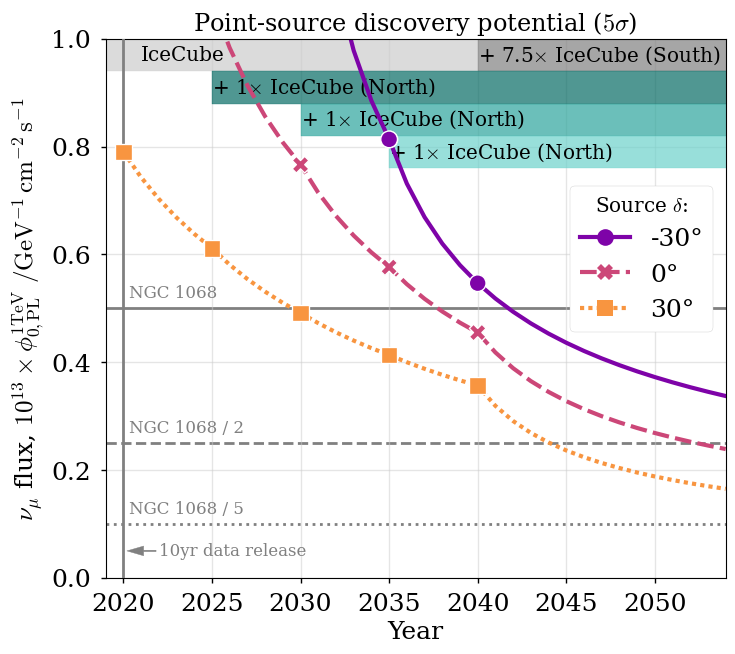

In [38]:
f, ax = plt.subplots(figsize=(8, 7))
#f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.6e-1
font_color = "0.5"
sigma_ref = 5
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "10yr data release",
    (2020.2, 0.05),
    (2022, 0.05),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize="large"
)

for yr_i, series in start_dates.iterrows():
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle((series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.7)
    )
    ax.text(
        x=series.Year if yr_i != "IceCube" else 2021,
        y=edge + 0.5 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize="x-large",
        zorder=2,
    )

ax = sns.lineplot(
    data=flux.loc[flux.sigma == sigma_ref],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
)


selection = flux.loc[flux.sigma == sigma_ref]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)
# extra plotting for legend
selection = flux.loc[flux.sigma == sigma_ref]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3, ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
)

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    title="Source $\delta$:",
)
plt.setp(legend.get_title(), fontsize="x-large")
for line in legend.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

ax.set_xlim(2019, yr_max-1)
ax.set_ylabel(
    r"$\nu_\mu$ flux, $10^{13} \times \phi_{0, \rm PL}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)

for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_flux.norm * 1e13 / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + ngc_flux.norm * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large"
    )

ax.grid(alpha=0.5)

ax.set_title(
    "Point-source discovery potential ($5 \sigma$)",
    fontsize="xx-large"
)
#f.tight_layout()
f.savefig("../../plots/ngc_paper/time_evolution_significance_ps.pdf")

## spectral analysis

In [30]:
thresholds = [sigma3]  # , sigma5]
decs = [-30, 0, 30]
detector_keys = ["IceCube", "KM3NeT", "Baikal-GVD", "P-ONE", "Gen-2"]


In [31]:
tmp = []  # save output here

# different energy resolutions for different detectors
eres_per_det = {
    "IceCube": improved_eres,
    "Baikal-GVD": improved_eres,
    "P-ONE": improved_eres,
    "KM3NeT": improved_eres,
    "Gen-2": improved_eres,
}

for dec, yr_i in product(decs, Years):
    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k_b = []
    all_k_s = []
    sum_s = 0
    sum_b = 0
    all_bckg_flux = []
    all_eres = []

    rad_dec = np.deg2rad(dec)
    # skip Southern Sky for IceCube-only config
    if dec < 0 and yr_i <= 2025:
        continue

    for ident in detector_keys:
        # skip calculation if detector isn't on yet
        if yr_i <= start_dates.loc[ident]["Year"]:
            continue

        # IceCube has an end-time within our time frame (=Gen2 start-time)
        # so it has a maximum contribution time here
        if (ident == "IceCube") and (yr_i >= start_dates.loc[ident]["end"]):
            new_rel_time = (
                start_dates.loc[ident]["end"] - start_dates.loc[ident]["Year"]
            ) / icecube_ref_time
        # otherwise, just calculate the diff between start time and current time
        else:
            new_rel_time = (yr_i - start_dates.loc[ident]["Year"]) / icecube_ref_time

        aeff_factor_bckg = (
            calc_aeff_factor(aeff_2d[ident], dec=rad_dec, **bg_config) * new_rel_time
        )
        aeff_factor_signal = (
            calc_aeff_factor(aeff_2d[ident], dec=rad_dec, **src_config) * new_rel_time
        )
        bckg_flux = array_source_interp(rad_dec, bckg_histo[ident], st.sindec_mids, axis=1)
        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            bckg_flux,
            energy_resolution=improved_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            st.emids,
            energy_resolution=improved_eres,
            phi_scaling=1,
            flux_shape=ngc_cut_flux,
        )

        sum_s += np.sum(k_s)
        sum_b += np.sum(k_b)

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k_b.append(k_b)
        all_k_s.append(k_s)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(improved_eres)

    all_k_s = np.array(all_k_s)
    all_k_b = np.array(all_k_b)

    # calculate an estimate for the flux scaling
    scaler = 8 / (sum_s / np.sqrt(sum_b))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        scaled_k_s = all_k_s * scaler
        all_k = scaled_k_s + all_k_b

        dct = dict(
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_cut_flux.E0,
            phi_0=ngc_cut_flux.norm,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2, 1.2, st.GAMMA_NGC),
            bounds=[(0, 10), (0, 10), (1, 5)],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
            approx_grad=True,
        )

        tmp_dct = {
            "dec_label": f"{dec}°",
            "dec": dec,
            "Year": yr_i,
            "scaler": scaler,
            # "cur_thresh": current_thresholds[0],
            "SosB": np.sum(scaled_k_s) / np.sqrt(np.sum(all_k_b)),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(scaled_k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)), # 1 ndof
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.Year == yr_i)
            # & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.1
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "timeline_disc_pot_spectral.pickle"))

### plotting

In [40]:
df = pd.read_pickle(join(LOCALPATH, "timeline_disc_pot_spectral.pickle"))

flux = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
flux["sigma"] = 3

tmp = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma5))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 5

flux = pd.concat([flux, tmp], ignore_index=True)

tmp = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma2))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 2

flux = pd.concat([flux, tmp], ignore_index=True)

flux["scaled_flux"] = flux.dp_flux * 1E13

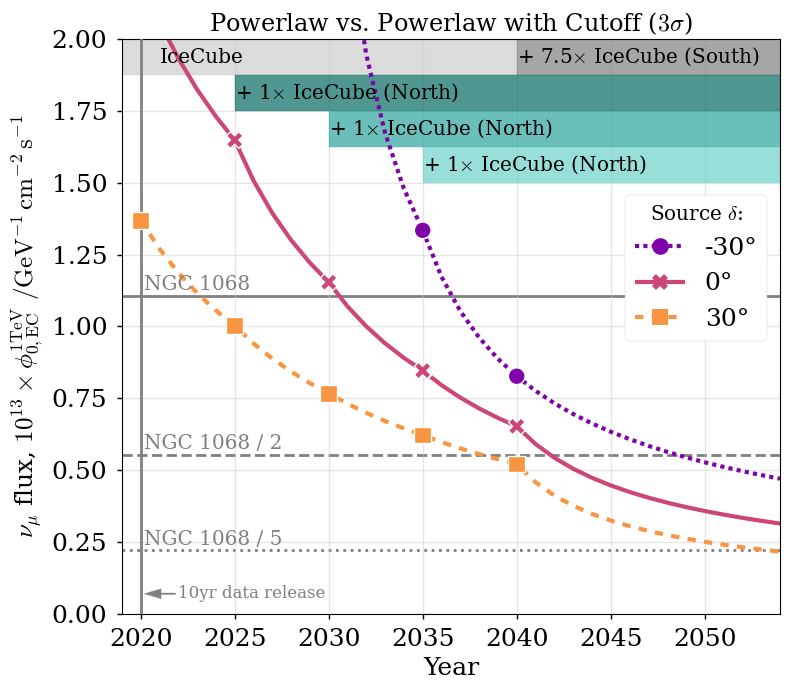

In [41]:
f, ax = plt.subplots(figsize=(8, 7))

edge = 2
ax.set_ylim(0, edge)

width = 1.25e-1
font_color = "0.5"

ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "10yr data release",
    (2020.2, 0.07),
    (2022, 0.07),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize="large"
)

for yr_i, series in start_dates.iterrows():
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle((series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.7)
    )
    ax.text(
        x=series.Year if yr_i != "IceCube" else 2021,
        y=edge + 0.5 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize="x-large",
        zorder=20,
    )

ax = sns.lineplot(
    data=flux.loc[flux.sigma == 3],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    dashes=[(1, 1), (1, 0), (2, 2)],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
)


selection = flux.loc[flux.sigma == 3]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)

selection = flux.loc[flux.sigma == 3]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    dashes=[(1, 1), (1, 0), (2, 2)],
    style="dec_label",
    units="dec",
    lw=3, ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
)

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    title="Source $\delta$:",
)
plt.setp(legend.get_title(), fontsize="x-large")
for line in legend.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

ax.set_xlim(2019, yr_max-1)
ax.set_ylabel(
    r"$\nu_\mu$ flux, $10^{13} \times \phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)

for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_cut_flux.norm * 1e13 / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.2,
        y=0.02 + ngc_cut_flux.norm * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="x-large"
    )

ax.grid(alpha=0.5)

ax.set_title(
    "Powerlaw vs. Powerlaw with Cutoff ($3 \sigma$)",
    fontsize="xx-large"
)
f.tight_layout()
f.savefig("../../plots/ngc_paper/time_evolution_significance_spectral.pdf")